# Sample1 차선 내에서 정확한 위치 뽑아내기 코드 
### 대상 차량: vehicle0, vehicle1, vehicle8

lane intersections structure  
* key: vehicle num  
* val[i][0]: frame num  
* val[i][1]: vehicle 좌표  
* val[i][2:]: vehicle 좌표에서 수평선을 그었을 때 차선과의 교점  
모든 좌표는 lane net 결과 기준 (512, 256)

depth_map_list
* 150개의 이미지에 대한 1080 * 1920 픽셀의 depth map 값이 3중 리스트로 만들어져 있음

In [115]:
import json
import numpy as np
import os

with open('result.json', 'r') as file:
    lane_intersections = json.load(file)
print(lane_intersections)

def load_npy_files(directory):
    npy_files = [f for f in os.listdir(directory) if f.endswith('metric_depth.npy')]
    data_list = []
    for file in npy_files:
        data = np.load(os.path.join(directory, file))
        data_list.append(data)
    return data_list

directory_path = 'content/object_depths'
depth_map_list = load_npy_files(directory_path)

{'vehicle0': [[0, [118, 280], [118, 237.0], [118, 266.5], [118, 289.5]], [1, [118, 280], [118, 236.5], [118, 266.0], [118, 289.5]], [2, [119, 280], [119, 236.5], [119, 267.0], [119, 291.5]], [3, [119, 281], [119, 235.5], [119, 268.0], [119, 292.0]], [5, [119, 281], [119, 234.0], [119, 267.5], [119, 291.0]], [6, [119, 282], [119, 235.0], [119, 265.5], [119, 290.0]], [7, [119, 282], [119, 236.5], [119, 265.0], [119, 292.5]], [8, [119, 283], [119, 236.5], [119, 266.5], [119, 292.5]], [9, [119, 283], [119, 237.5], [119, 267.5], [119, 291.0]], [10, [119, 283], [119, 236.0], [119, 267.0], [119, 290.0]], [11, [119, 284], [119, 235.0], [119, 268.0], [119, 292.5]], [12, [119, 284], [119, 230.0], [119, 266.5], [119, 290.5]], [13, [119, 285], [119, 233.5], [119, 267.0], [119, 291.5]], [14, [119, 285], [119, 229.0], [119, 266.0], [119, 291.0]], [15, [119, 285], [119, 225.5], [119, 267.5], [119, 293.0]], [17, [119, 286], [119, 234.0], [119, 266.5], [119, 292.5]], [18, [119, 287], [119, 234.5], [119

In [116]:
# resizing 
lheight, lwidth =  256, 512 # lane net size
dheight, dwidth = depth_map_list[0].shape # depth map size

print(f"lanenet size: {lheight, lwidth}")
print(f"depth map size: {dheight, dwidth}")

resizing_val = dheight/lheight, dwidth/lwidth
print(f"resizing value: {resizing_val}")

lanenet size: (256, 512)
depth map size: (1080, 1920)
resizing value: (4.21875, 3.75)


In [117]:
for vehicle, values in lane_intersections.items():
    print(f"{vehicle}: {len(values)}")
    for value in values:
        for points in value[1:]:
            points[0] *= resizing_val[0]
            points[1] *= resizing_val[1]

vehicle0: 117
vehicle1: 77
vehicle8: 31


In [118]:
fx, fy, cx, cy = 1316.81, 738.72, 960, 540
def get_3dpoint(frame_num, v, u):
    depth = depth_map_list[frame_num]
    d = depth[v,u]
    Z = d
    X = (v - cx) * Z / fx
    Y = (u - cy) * Z / fy
    return [X, Y, Z]

### 교점 확인  
이미지에 교점 직접 찍어봄

In [119]:
idx=0
print(lane_intersections.keys())
vehicle = 'vehicle0'

dict_keys(['vehicle0', 'vehicle1', 'vehicle8'])


1
497 1050
[-18.70068379868272, 36.71892269320539, 53.18627955279351]
497 886
[-16.285436395702664, 21.69390666020966, 46.31711771106959]
497 997
[-12.08412385877846, 21.261487029237877, 34.36824003990942]
497 1085
[-21.100687036914255, 44.27467339135702, 60.012085738831665]


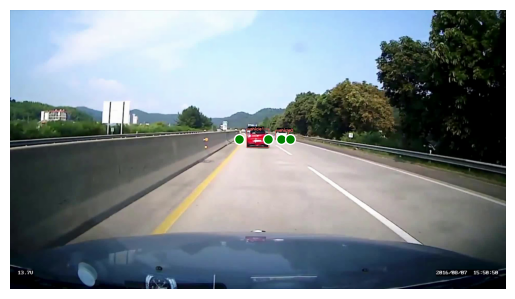

In [120]:
import random
import cv2
import matplotlib.pyplot as plt

idx += 1
print(idx)

frame_num = lane_intersections[vehicle][idx][0]
img_path = f'content/tracker/{frame_num:06d}.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

for point in lane_intersections[vehicle][idx][1:]:
    v, u = int(point[0]), int(point[1])
    plt.scatter([u], [v], color='green', s=50, edgecolor='white')
    print(v, u)
    print(get_3dpoint(frame_num, v, u))

plt.axis('off')
plt.show()

In [121]:
# vehicle당 모든 [frame_num, vehicle coor, lane coors] 계산
# depth map size: (1080, 1920)
realworld_values = {}
for vehicle, values in lane_intersections.items():
    points3d = []
    for value in values:
        frame_num = value[0]
        point3d = [frame_num]
        for points in value[1:]:
            point3d.append(get_3dpoint(frame_num, int(points[0]), int(points[1])))
        points3d.append(point3d)
    realworld_values[vehicle] = points3d

차선이 여러 개 있을 때, 차선 사이 폭이 모두 똑같다고 가정  
frame마다 value가 있고, 차선 사이 폭의 평균 계산 -> average_width    
계산된 frame당 평균 차선 폭의 평균을 구함  


In [122]:
# lane width 계산
lane_widths_dict = {}

for vehicle, values in realworld_values.items():
    all_widths = []
    for frame_value in values:
        lane_num = len(frame_value)-2
        frame_widths = []
        # 차선의 좌표들로 차선 폭 계산
        for idx in range(lane_num-1):
            frame_width = np.linalg.norm(np.array(frame_value[idx+2]) - np.array(frame_value[idx+3])) # frame num, vehicle coor 제외  
            frame_widths.append(frame_width)
        all_widths.append(np.mean(frame_widths))
    lane_widths_dict[vehicle] = np.mean(all_widths)

In [123]:
from scipy.stats import mode
import numpy as np

# lane width 계산
lane_widths_dict = {}

for vehicle, values in realworld_values.items():
    all_widths = []
    for frame_value in values:
        lane_num = len(frame_value) - 2
        # 차선의 좌표들로 차선 폭 계산
        for idx in range(lane_num - 1):
            frame_width = np.linalg.norm(np.array(frame_value[idx+2]) - np.array(frame_value[idx+3])) # frame num, vehicle coor 제외
            all_widths.append(frame_width)
    
    # all_widths에서 최빈값 계산
    if len(all_widths) > 0:
        mode_result = mode(all_widths)
        print(vehicle, mode_result)
        print(mode_result)  # mode_result의 구조를 확인합니다
        if mode_result.mode.size > 0:  # mode_result.mode가 빈 배열이 아닌지 확인
            lane_widths_dict[vehicle] = mode_result.mode
        else:
            lane_widths_dict[vehicle] = None  # 최빈값이 없는 경우 처리
    else:
        lane_widths_dict[vehicle] = None  # 데이터가 없는 경우 처리


vehicle0 ModeResult(mode=4.712286496076135, count=1)
ModeResult(mode=4.712286496076135, count=1)
vehicle1 ModeResult(mode=4.877310855624132, count=1)
ModeResult(mode=4.877310855624132, count=1)
vehicle8 ModeResult(mode=7.388800772081441, count=1)
ModeResult(mode=7.388800772081441, count=1)


In [124]:
lane_widths_dict
valid_values = [value for value in lane_widths_dict.values() if value is not None]
lane_width = np.median(valid_values)


for i in lane_widths_dict.keys():
    if lane_widths_dict[i]==None:
        lane_widths_dict[i]=lane_width

차량 위치 계산  
1. 차량이 차선 사이에 위치 : 차량 x좌표가 min도 아니고 max도 아님    
2. 차량이 가장자리에 위치 : 차량 x좌표가 min혹은 max  

In [125]:
lane_ratios = {}
for vehicle, values in lane_intersections.items():
    vehicle_lane_ratios = []
    for value in values:
        frame_num = value[0]
        x = sorted(value[1:], key=lambda x: x[1])
        for vehicle_idx in range(len(x)):
            if value[1][1] == x[vehicle_idx][1]:
                break
        if vehicle_idx==0:
            # 차량이 왼쪽 끝에 위치
            if (len(x)<=1):
                continue

            else :
                lane1 = get_3dpoint(frame_num, int(x[vehicle_idx+1][0]), int(x[vehicle_idx+1][1]))
                vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

                lane_width = lane_widths_dict[vehicle]
                ratio2 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
                ratio1 = 1-ratio2

                if ratio1 < 0 or ratio2 < 0:
                    print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

                vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])

        elif vehicle_idx==len(x)-1:

            # 차량이 오른쪽 끝에 위치
            lane1 = get_3dpoint(frame_num, int(x[vehicle_idx-1][0]), int(x[vehicle_idx-1][1]))
            vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

            lane_width = lane_widths_dict[vehicle]
            ratio1 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
            ratio2 = 1-ratio1

            if ratio1 < 0 or ratio2 < 0:
                print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

            vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])

        else:

            lane1 = get_3dpoint(frame_num, int(x[vehicle_idx-1][0]), int(x[vehicle_idx-1][1]))
            lane2 = get_3dpoint(frame_num, int(x[vehicle_idx+1][0]), int(x[vehicle_idx+1][1]))
            vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

            lane_width = np.linalg.norm(np.array(lane2) - np.array(lane1))
            ratio1 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
            ratio2 = np.linalg.norm(np.array(lane2) - np.array(vehicle_point)) / lane_width
            
            ratio_sum = ratio1+ratio2
            ratio1 = ratio1/ratio_sum
            ratio2 = ratio2/ratio_sum
            if ratio1 < 0 or ratio2 < 0:
                print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

            vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])
    lane_ratios[vehicle] = vehicle_lane_ratios
        

vehicle0 44: ratio1=1.7694544926555151, ratio2=-0.7694544926555151/ 4.712286496076135
vehicle0 45: ratio1=1.9629850411711987, ratio2=-0.9629850411711987/ 4.712286496076135
vehicle0 47: ratio1=2.078155537940404, ratio2=-1.078155537940404/ 4.712286496076135
vehicle0 48: ratio1=2.0303314811584774, ratio2=-1.0303314811584774/ 4.712286496076135
vehicle0 49: ratio1=1.6809111247751223, ratio2=-0.6809111247751223/ 4.712286496076135
vehicle0 50: ratio1=1.3563974589674523, ratio2=-0.35639745896745234/ 4.712286496076135
vehicle0 51: ratio1=1.0609316083568432, ratio2=-0.06093160835684319/ 4.712286496076135
vehicle0 52: ratio1=1.1359417095542894, ratio2=-0.1359417095542894/ 4.712286496076135


### 비율 음수인 경우 주변값의 평균값으로 값 대체
값이 음수이거나 lanewidth보다 큰 값일 경우 주변값들의 평균값으로 대체해주었다.

In [126]:

for key, items in lane_ratios.items():
    for i in range(len(lane_ratios[key])):
        if lane_ratios[key][i][2]<0 or lane_ratios[key][i][2]>1:
            index_1=0
            index_2=0
            if i==0:    
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=index_2=j
                        break
            elif i==len(lane_ratios[key])-1:
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=index_2=j
                        break
            else:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=j
                        break
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][2]<1:
                        index_2=j
                        break
            lane_ratios[key][i][2] = (lane_ratios[key][index_1][2] + lane_ratios[key][index_2][2])/2

        if lane_ratios[key][i][3]<0 or lane_ratios[key][i][3]>1:
            index_1=0
            index_2=0
            if i==0:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=index_2=j
                        break
            elif i==len(lane_ratios[key])-1:
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=index_2=j
                        break
            else:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=j
                        break
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][3]<1:
                        index_2=j
                        break
            lane_ratios[key][i][3] = (lane_ratios[key][index_1][3] + lane_ratios[key][index_2][3])/2    
        


### 값이 음수가 나오는 차량 찍어보기

In [127]:
for key, items in lane_ratios.items():
    for i in range(len(lane_ratios[key])):
        if lane_ratios[key][i][2]<0 or lane_ratios[key][i][3]<0:
            print(key,": ",lane_ratios[key][i][2], lane_ratios[key][i][3]) 

### vehicel 0, vehicle 1, vehicle8의 정보에 집중

In [128]:
filtered_lane_ratios = {
    "vehicle0": lane_ratios.get("vehicle0"),
    "vehicle1": lane_ratios.get("vehicle1"),
    "vehicle8": lane_ratios.get("vehicle8")
}

### lane_postion을 json 파일로 저장

In [129]:
import json
file_path = 'lane_ratio.json'
with open(file_path, 'w', encoding='utf-8') as json_file:
            json.dump(filtered_lane_ratios, json_file, ensure_ascii=False, indent=4)

## 빈값 채우기 - lane_ratio_filled.json

In [130]:
import json
import numpy as np

# JSON 파일 경로
input_file_path = 'lane_ratio.json'
output_file_path = 'lane_ratio_filled.json'

def fill_missing_frames(vehicle_data):
    if not vehicle_data:
        # vehicle_data가 빈 리스트일 경우 처리하지 않음
        return
    
    # 프레임 번호를 가져와서 누락된 프레임을 찾습니다.
    frames = [frame[0] for frame in vehicle_data]
    min_frame, max_frame = min(frames), max(frames)
    all_frames = set(range(min_frame, max_frame + 1))
    missing_frames = sorted(all_frames - set(frames))
    
    # 누락된 프레임에 대해 주변값을 사용하여 채웁니다.
    for missing_frame in missing_frames:
        # 채울 값들을 찾습니다.
        prev_frame = max([frame for frame in frames if frame < missing_frame], default=None)
        next_frame = min([frame for frame in frames if frame > missing_frame], default=None)
        
        if prev_frame is not None:
            # 이전 프레임의 값을 사용합니다.
            prev_value = [frame for frame in vehicle_data if frame[0] == prev_frame][0]
            new_frame = [missing_frame, prev_value[1], prev_value[2], prev_value[3]]
        elif next_frame is not None:
            # 다음 프레임의 값을 사용합니다 (이 경우, 처음 프레임이 없을 때만).
            next_value = [frame for frame in vehicle_data if frame[0] == next_frame][0]
            new_frame = [missing_frame, next_value[1], next_value[2], next_value[3]]
        
        # 새로운 데이터를 추가합니다.
        vehicle_data.append(new_frame)
    
    # 프레임 번호를 기준으로 데이터를 정렬합니다.
    vehicle_data.sort(key=lambda x: x[0])

# JSON 파일 읽기
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# 각 차량에 대해 누락된 프레임을 채우기
for vehicle in data:
    fill_missing_frames(data[vehicle])

# 채워진 데이터를 새로운 JSON 파일로 저장
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"Missing frames filled and saved to {output_file_path}")


Missing frames filled and saved to lane_ratio_filled.json


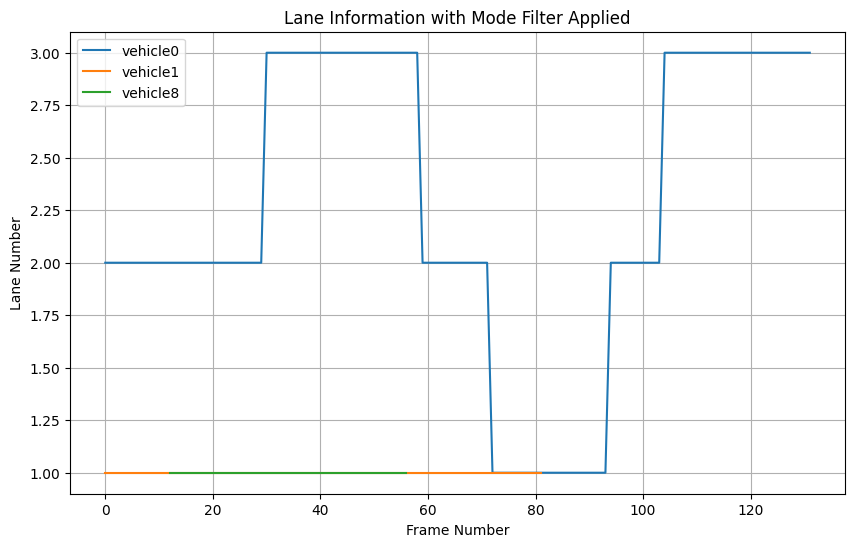

{'vehicle0': [[0, 2, 0.6694740940773835, 0.33052590592261655], [1, 2, 0.7069379114484781, 0.2930620885515219], [2, 2, 0.6306209749492788, 0.36937902505072107], [3, 2, 0.5379259368795344, 0.4620740631204656], [4, 2, 0.5379259368795344, 0.4620740631204656], [5, 2, 0.6523549361152946, 0.3476450638847054], [6, 2, 0.9034504733764228, 0.09654952662357724], [7, 2, 0.8384130831871267, 0.16158691681287332], [8, 2, 0.903862653731871, 0.09613734626812886], [9, 2, 0.8647009781736411, 0.13529902182635886], [10, 2, 0.9455847700650617, 0.05441522993493834], [11, 2, 0.8904321317252375, 0.10956786827476249], [12, 2, 0.8153497929936825, 0.18465020700631757], [13, 2, 0.8002091866666105, 0.19979081333338972], [14, 2, 0.8915682829127661, 0.10843171708723388], [15, 2, 0.788711933658982, 0.211288066341018], [16, 2, 0.788711933658982, 0.211288066341018], [17, 2, 0.8667355454926869, 0.133264454507313], [18, 2, 0.7812437800038, 0.21875621999620004], [19, 2, 0.8601294731543966, 0.13987052684560336], [20, 2, 0.83

In [131]:
from scipy.stats import mode
import matplotlib.pyplot as plt

def mode_filter(data, window_size=5):
    # 결과를 담을 사전
    filtered_data = {}

    for vehicle, values in data.items():
        lanes = [entry[1] for entry in values]
        
        # 모드 필터를 적용
        filtered_lanes = []
        for i in range(len(lanes)):
            # 현재 값 주변의 값들을 윈도우로 선택
            start = max(0, i - window_size // 2)
            end = min(len(lanes), i + window_size // 2 + 1)
            window = lanes[start:end]
            
            # 윈도우 내에서 가장 빈도가 높은 값(모드) 계산
            most_common_result = mode(window, keepdims=True)  # keepdims=True 옵션 추가
            most_common = most_common_result.mode[0]  # 배열 형태로 반환되므로 안전하게 인덱싱 가능
            filtered_lanes.append(int(most_common))
        
        # 필터링된 결과를 데이터에 반영
        filtered_data[vehicle] = [[values[i][0], filtered_lanes[i]] for i in range(len(values))]

    return filtered_data

with open('lane_ratio_filled.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# 모드 기반 필터 적용
filtered_data = mode_filter(data, window_size=5)

# 원본 데이터를 필터링된 값으로 덮어쓰기
for vehicle in data.keys():
    for i in range(len(data[vehicle])):
        data[vehicle][i][1] = filtered_data[vehicle][i][1]

# 그래프 그리기
plt.figure(figsize=(10, 6))
for vehicle, values in data.items():
    frames = [entry[0] for entry in values]
    lanes = [entry[1] for entry in values]
    
    plt.plot(frames, lanes, label=vehicle)

# 그래프 설정
plt.xlabel("Frame Number")
plt.ylabel("Lane Number")
plt.title("Lane Information with Mode Filter Applied")
plt.legend()
plt.grid(True)
plt.show()

print(data)


## 차량별로 도로에서 비율을 도입한 정확한 위치 계산하기

In [132]:

exact_postion={}
for car in data.keys():
    tmp=[]
    for i in range(len(data[car])):
        tmp.append([data[car][i][0], data[car][i][1]+data[car][i][2]])
    exact_postion[car]=tmp
print(exact_postion)



{'vehicle0': [[0, 2.6694740940773833], [1, 2.706937911448478], [2, 2.630620974949279], [3, 2.5379259368795344], [4, 2.5379259368795344], [5, 2.6523549361152945], [6, 2.903450473376423], [7, 2.8384130831871266], [8, 2.903862653731871], [9, 2.864700978173641], [10, 2.9455847700650617], [11, 2.8904321317252375], [12, 2.8153497929936826], [13, 2.8002091866666103], [14, 2.891568282912766], [15, 2.788711933658982], [16, 2.788711933658982], [17, 2.866735545492687], [18, 2.7812437800038], [19, 2.8601294731543967], [20, 2.8373507758251], [21, 2.877709059630158], [22, 2.905343927379758], [23, 2.9037913026249034], [24, 2.9491270751149363], [25, 2.9733187329041977], [26, 2.077547191111301], [27, 2.98013859023579], [28, 2.9944956933919493], [29, 3.0], [30, 3.104497704484928], [31, 3.1991856789013227], [32, 3.2704827848551417], [33, 3.435503403445245], [34, 3.2686918240078406], [35, 3.24134025766619], [36, 3.354749295152616], [37, 3.3063540338166204], [38, 3.959986854615811], [39, 3.4094855393466688

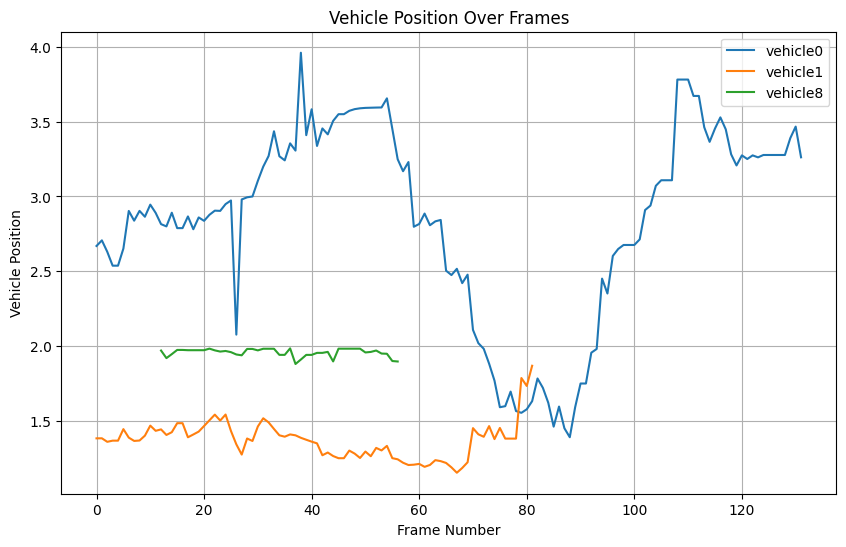

In [133]:
plt.figure(figsize=(10, 6))
for vehicle, positions in exact_postion.items():
    # 프레임 번호와 위치 값을 분리
    frames = [pos[0] for pos in positions]
    locations = [pos[1] for pos in positions]
    
    # 라인 그래프 그리기
    plt.plot(frames, locations, label=vehicle)

# 그래프 설정
plt.xlabel('Frame Number')
plt.ylabel('Vehicle Position')
plt.title('Vehicle Position Over Frames')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
print(exact_postion)

{'vehicle0': [[0, 2.6694740940773833], [1, 2.706937911448478], [2, 2.630620974949279], [3, 2.5379259368795344], [4, 2.5379259368795344], [5, 2.6523549361152945], [6, 2.903450473376423], [7, 2.8384130831871266], [8, 2.903862653731871], [9, 2.864700978173641], [10, 2.9455847700650617], [11, 2.8904321317252375], [12, 2.8153497929936826], [13, 2.8002091866666103], [14, 2.891568282912766], [15, 2.788711933658982], [16, 2.788711933658982], [17, 2.866735545492687], [18, 2.7812437800038], [19, 2.8601294731543967], [20, 2.8373507758251], [21, 2.877709059630158], [22, 2.905343927379758], [23, 2.9037913026249034], [24, 2.9491270751149363], [25, 2.9733187329041977], [26, 2.077547191111301], [27, 2.98013859023579], [28, 2.9944956933919493], [29, 3.0], [30, 3.104497704484928], [31, 3.1991856789013227], [32, 3.2704827848551417], [33, 3.435503403445245], [34, 3.2686918240078406], [35, 3.24134025766619], [36, 3.354749295152616], [37, 3.3063540338166204], [38, 3.959986854615811], [39, 3.4094855393466688

In [135]:
import pandas as pd


longest_key = max(exact_postion, key=lambda k: len(exact_postion[k]))
n = len(exact_postion[longest_key])  # 프레임 수가 가장 큰 것으로 맞추기
iter = len(exact_postion.keys())  # 차량의 수만큼 반복

tmp = [[None] * n for _ in range(iter)]
linear_tmp = []

# 일단 빈 리스트에 값을 채워준다.
for i, car in enumerate(exact_postion.keys()) :
        for j in range(len(exact_postion[car])):
                tmp[i][exact_postion[car][j][0]] = exact_postion[car][j][1]  # Proper indentation for nested loops

# 선형 보간을 해준다
for i in range(iter):
        z_series = pd.Series(tmp[i])
        linear_tmp.append(z_series.interpolate(method='linear', limit_direction='both').to_numpy().tolist())
# print(linear_tmp)

# 다시 원본 데이터를 저장해준다.
result={}
for i, car in enumerate(exact_postion.keys()) :
        tmp=[]
        for j in range(n):
                tmp.append([j, linear_tmp[i][j]])
        result[car] = tmp

exact_postion=result

print(exact_postion)


{'vehicle0': [[0, 2.6694740940773833], [1, 2.706937911448478], [2, 2.630620974949279], [3, 2.5379259368795344], [4, 2.5379259368795344], [5, 2.6523549361152945], [6, 2.903450473376423], [7, 2.8384130831871266], [8, 2.903862653731871], [9, 2.864700978173641], [10, 2.9455847700650617], [11, 2.8904321317252375], [12, 2.8153497929936826], [13, 2.8002091866666103], [14, 2.891568282912766], [15, 2.788711933658982], [16, 2.788711933658982], [17, 2.866735545492687], [18, 2.7812437800038], [19, 2.8601294731543967], [20, 2.8373507758251], [21, 2.877709059630158], [22, 2.905343927379758], [23, 2.9037913026249034], [24, 2.9491270751149363], [25, 2.9733187329041977], [26, 2.077547191111301], [27, 2.98013859023579], [28, 2.9944956933919493], [29, 3.0], [30, 3.104497704484928], [31, 3.1991856789013227], [32, 3.2704827848551417], [33, 3.435503403445245], [34, 3.2686918240078406], [35, 3.24134025766619], [36, 3.354749295152616], [37, 3.3063540338166204], [38, 3.959986854615811], [39, 3.4094855393466688

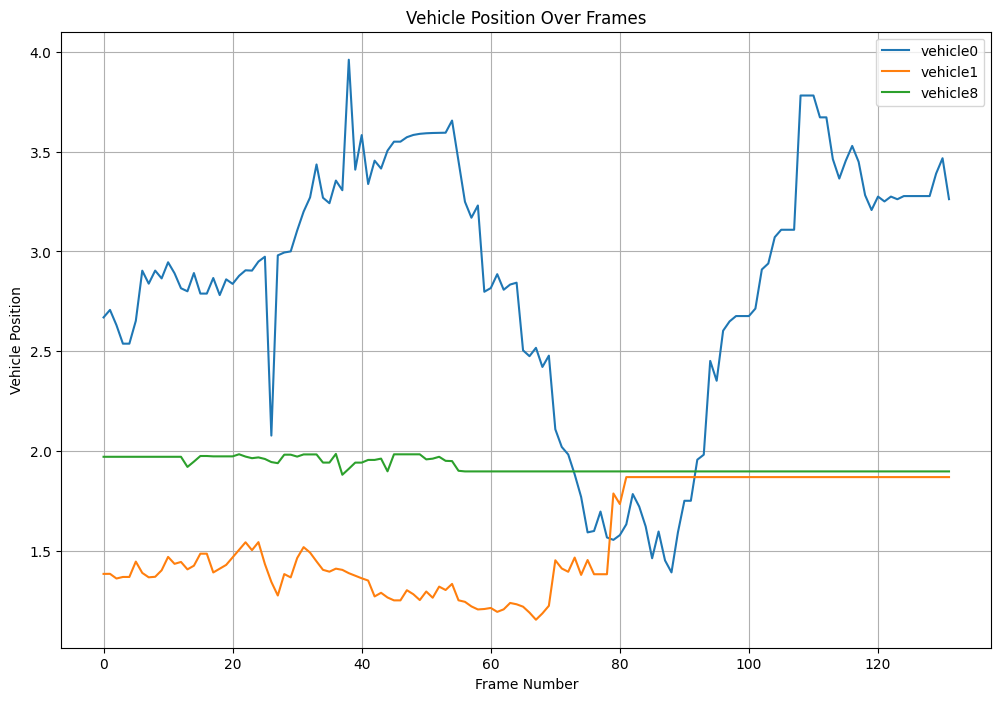

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

# exact_postion 값 그래프 그리기
plt.figure(figsize=(12, 8))

for car, positions in exact_postion.items():
    # 각 차량의 프레임과 위치 데이터 분리
    frames = [pos[0] for pos in positions]
    locations = [pos[1] for pos in positions]
    
    # 차량별로 그래프를 그리기
    plt.plot(frames, locations, label=car)

# 그래프 설정
plt.xlabel('Frame Number')
plt.ylabel('Vehicle Position')
plt.title('Vehicle Position Over Frames')
plt.legend()
plt.grid(True)
plt.show()


In [137]:
import json
import pandas as pd

# (중간 코드 생략)

# exact_postion을 JSON 파일로 저장하는 코드
with open('exact_position.json', 'w') as json_file:
    json.dump(exact_postion, json_file, indent=4)

print("exact_postion 데이터가 'exact_postion.json' 파일로 저장되었습니다.")

exact_postion 데이터가 'exact_postion.json' 파일로 저장되었습니다.


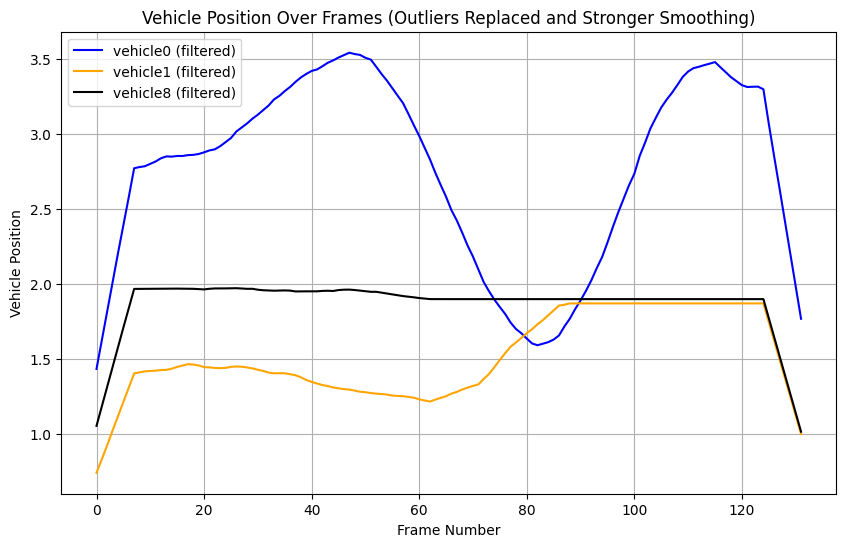

In [138]:
import numpy as np
import matplotlib.pyplot as plt

def replace_outliers_with_mean(positions, threshold=0.5):
    """
    특정 위치에서 급격한 변화가 나타나는 outlier 값을 감지하여
    양 옆 값의 평균으로 대체
    """
    new_positions = positions.copy()
    locations = [pos[1] for pos in positions]  # 위치 값 추출

    for i in range(1, len(locations) - 1):
        # 앞뒤 값과의 차이를 확인하여 threshold보다 크면 outlier로 간주
        if abs(locations[i] - locations[i - 1]) > threshold and abs(locations[i] - locations[i + 1]) > threshold:
            # outlier를 양 옆 값의 평균으로 대체
            new_positions[i][1] = (locations[i - 1] + locations[i + 1]) / 2

    return new_positions

def smooth_data(locations, window_size=15):
    """
    이동 평균 필터를 사용하여 데이터를 스무딩합니다.
    """
    return np.convolve(locations, np.ones(window_size) / window_size, mode='same')

# outlier 제거 및 스무딩 후 그래프 그리기
plt.figure(figsize=(10, 6))

# vehicle0: 파란색, vehicle1: 주황색
colors = ['blue', 'orange','black']

for idx, (vehicle, positions) in enumerate(exact_postion.items()):
    # outlier 제거 후 위치 정보 업데이트
    filtered_positions = replace_outliers_with_mean(positions, threshold=0.5)
    
    # 프레임 번호와 위치 값을 분리
    frames = [pos[0] for pos in filtered_positions]
    locations = [pos[1] for pos in filtered_positions]
    
    # 스무딩 적용 (윈도우 크기 15로 증가)
    smoothed_locations = smooth_data(locations, window_size=15)

    for i in range(len(filtered_positions)):
        filtered_positions[i][1] = smoothed_locations[i]

    # 라인 그래프 그리기 (색상 지정)
    plt.plot(frames, smoothed_locations, label=f"{vehicle} (filtered)", color=colors[idx])




# 그래프 설정
plt.xlabel('Frame Number')
plt.ylabel('Vehicle Position')
plt.title('Vehicle Position Over Frames (Outliers Replaced and Stronger Smoothing)')
plt.legend()
plt.grid(True)
plt.show()


In [139]:
import json

# Save exact_position as a JSON file
def save_to_json(data, filename="exact_position2.json"):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

# Usage
save_to_json(exact_postion)


In [140]:
lane_path='exact_position.json'
with open(lane_path, 'r', encoding='utf-8') as json_file:
    lane = json.load(json_file)

In [141]:
lane

{'vehicle0': [[0, 2.6694740940773833],
  [1, 2.706937911448478],
  [2, 2.630620974949279],
  [3, 2.5379259368795344],
  [4, 2.5379259368795344],
  [5, 2.6523549361152945],
  [6, 2.903450473376423],
  [7, 2.8384130831871266],
  [8, 2.903862653731871],
  [9, 2.864700978173641],
  [10, 2.9455847700650617],
  [11, 2.8904321317252375],
  [12, 2.8153497929936826],
  [13, 2.8002091866666103],
  [14, 2.891568282912766],
  [15, 2.788711933658982],
  [16, 2.788711933658982],
  [17, 2.866735545492687],
  [18, 2.7812437800038],
  [19, 2.8601294731543967],
  [20, 2.8373507758251],
  [21, 2.877709059630158],
  [22, 2.905343927379758],
  [23, 2.9037913026249034],
  [24, 2.9491270751149363],
  [25, 2.9733187329041977],
  [26, 2.077547191111301],
  [27, 2.98013859023579],
  [28, 2.9944956933919493],
  [29, 3.0],
  [30, 3.104497704484928],
  [31, 3.1991856789013227],
  [32, 3.2704827848551417],
  [33, 3.435503403445245],
  [34, 3.2686918240078406],
  [35, 3.24134025766619],
  [36, 3.354749295152616],
  

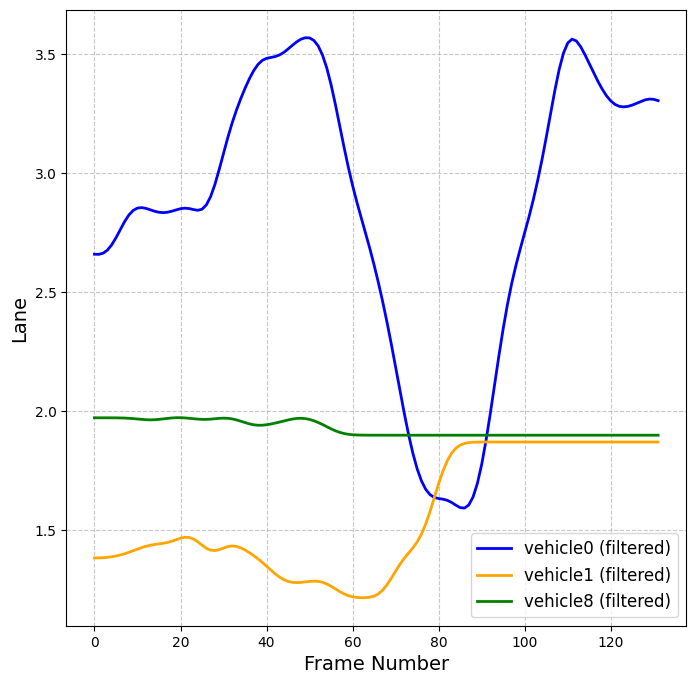

In [146]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# 예시 데이터 (frame, value)
# 필터링된 데이터를 저장할 딕셔너리
filtered_data = {}

# 색상 팔레트
colors = ['blue', 'orange', 'green']
sigma = 3  # 가우시안 필터 강도

# 그래프 생성
plt.figure(figsize=(8, 8))
for idx, (vehicle, entries) in enumerate(lane.items()):
    frames = [entry[0] for entry in entries]  # frame 추출
    values = [entry[1] for entry in entries]  # value 추출

    # 가우시안 필터 적용
    smoothed_values = gaussian_filter1d(values, sigma=sigma, mode='nearest')  # 경계 처리 포함

    # 필터링된 데이터를 다시 구성
    filtered_data[vehicle] = [[frame, value] for frame, value in zip(frames, smoothed_values)]

    # 그래프 그리기
    plt.plot(frames, smoothed_values, label=f"{vehicle} (filtered)", color=colors[idx], linewidth=2)

# 그래프 꾸미기
plt.xlabel("Frame Number", fontsize=14)
plt.ylabel("Lane", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [143]:
import json

# Save exact_position as a JSON file
def save_to_json(filtered_data, filename="exact_position3.json"):
    with open(filename, "w") as f:
        json.dump(filtered_data, f, indent=4)

# Usage
save_to_json(filtered_data)
